Load in all the needed libraries.

In [54]:
import pandas as pd

In [55]:
data = pd.read_csv('species-listings-by-tax-group-report.csv')
data.head(5)

# Rename columns scientific_name, common_name, listing_location, listing_region, esa_status and group
data.columns = ['scientific_name', 'common_name', 'listing_location', 'listing_region', 'esa_status', 'group']
data

,scientific_name,common_name,listing_location,listing_region,esa_status,group
0,Nerodia clarkii taeniata,Atlantic salt marsh snake,Wherever found,4,Threatened,Reptiles
1,Drosophila differens,Hawaiian picture-wing fly,Wherever found,1,Endangered,Insects
2,Ammodramus savannarum floridanus,Florida grasshopper sparrow,Wherever found,4,Endangered,Birds
3,Corvus leucognaphalus,White-necked crow,Wherever found,4,Endangered,Birds
4,Fusconaia cuneolus,Finerayed pigtoe,Wherever found; Except where listed as Experim...,4,Endangered,Clams
...,...,...,...,...,...,...
729,Rostrhamus sociabilis plumbeus,Everglade snail kite,Wherever found,4,Endangered,Birds
730,Hemignathus affinis,Maui nukupuu,Wherever found,1,Endangered,Birds
731,Thermosphaeroma thermophilus,Socorro isopod,Wherever found,2,Endangered,Crustaceans
732,Strix occidentalis caurina,Northern spotted owl,Wherever found,1,Threatened,Birds


In [56]:
# drop rows that are not in listing region 4
df = data.loc[(data['listing_region'] == 4)]

# Drop if their are birds, mammals, arachnids, insects and reptiles
df = df.loc[(df['group'] != 'Birds') & (df['group'] != 'Mammals') & (df['group'] != 'Arachnids') & (df['group'] != 'Insects') & (df['group'] != 'Reptiles')]

# save the data to a csv file called south.csv
df.to_csv('south.csv', index=False)
df

,scientific_name,common_name,listing_location,listing_region,esa_status,group
4,Fusconaia cuneolus,Finerayed pigtoe,Wherever found; Except where listed as Experim...,4,Endangered,Clams
7,Medionidus acutissimus,Alabama moccasinshell,Wherever found,4,Threatened,Clams
9,Fusconaia masoni,Atlantic pigtoe,Wherever found,4,Threatened,Clams
10,Pleurocera foremani,Rough hornsnail,Wherever found,4,Endangered,Snails
14,Epioblasma metastriata,Upland combshell,Wherever found,4,Endangered,Clams
...,...,...,...,...,...,...
695,Obovaria subrotunda,Round hickorynut,Wherever found,4,Threatened,Clams
706,Necturus lewisi,Neuse River waterdog,Wherever found,4,Threatened,Amphibians
709,Pleurobema perovatum,Ovate clubshell,Wherever found,4,Endangered,Clams
725,Cyprinella caerulea,Blue shiner,Wherever found,4,Threatened,Fishes


## Prepare data for exploratory visualization

In [57]:
# Remove duplicates in the scientific_name column
data = data.drop_duplicates(subset=['scientific_name'])

In [58]:
# Group data by taxonomic group and region and count the number of species in each group
grouped = data.groupby(['listing_region','group']).size().reset_index(name='count')
grouped

,listing_region,group,count
0,1,Amphibians,1
1,1,Arachnids,1
2,1,Birds,50
3,1,Crustaceans,3
4,1,Fishes,4
...,...,...,...
56,8,Fishes,28
57,8,Insects,25
58,8,Mammals,21
59,8,Reptiles,6


In [59]:
# create a new column which is true if listing_region is 4
grouped['is_4'] = grouped['listing_region'] == 4

In [60]:
grouped_status = data.groupby(['listing_region','group','esa_status']).size().reset_index(name='count')
grouped_status

,listing_region,group,esa_status,count
0,1,Amphibians,Threatened,1
1,1,Arachnids,Endangered,1
2,1,Birds,Endangered,42
3,1,Birds,"Experimental Population, Non-Essential",2
4,1,Birds,Threatened,6
...,...,...,...,...
108,8,Mammals,Endangered,17
109,8,Mammals,Threatened,4
110,8,Reptiles,Endangered,2
111,8,Reptiles,Threatened,4


In [61]:
# create a new column which is true if listing_region is 4
grouped_status['is_4'] = grouped_status['listing_region'] == 4

## Exploratory data analysis

In [62]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
%%R

require('tidyverse')

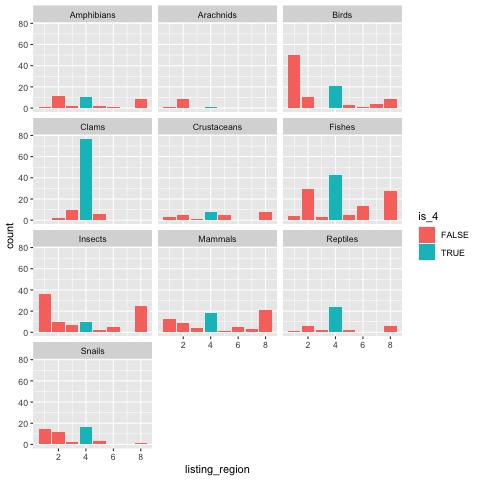

In [64]:
%%R -i grouped

ggplot(grouped, aes(x = listing_region, y = count, fill = is_4)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_wrap(~group, ncol=3)

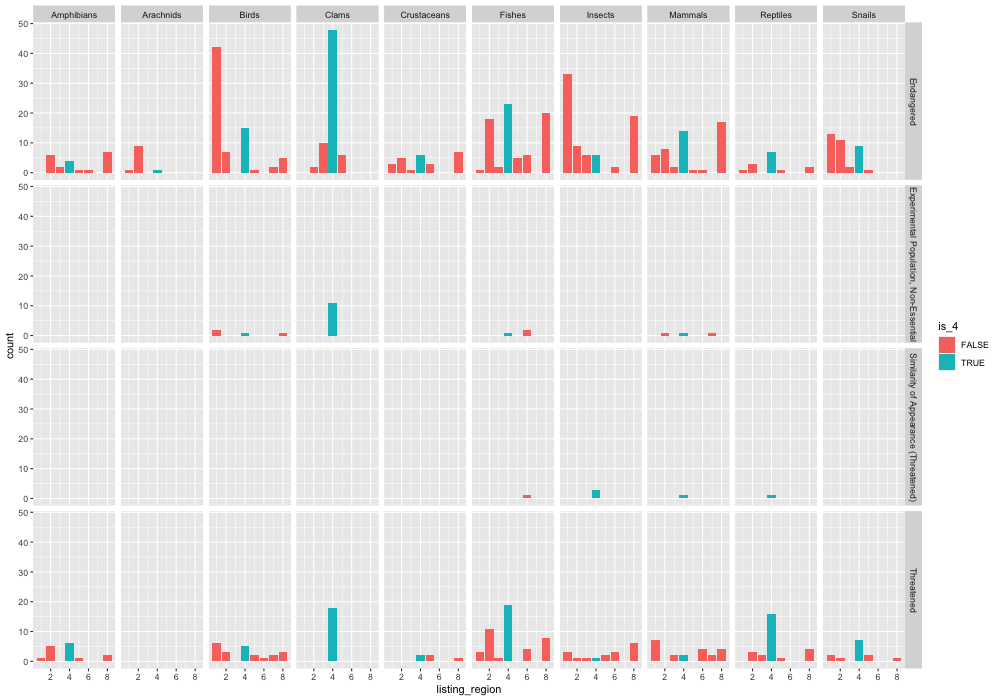

In [65]:
%%R -i grouped_status -h 700 -w 1000

ggplot(grouped_status, aes(x = listing_region, y = count, fill = is_4)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(esa_status ~ group)